In [1]:
# notebook for third canonical problem for multimodal optimization looking for localized extreme
# events with agent-based military simulation
# Experiment 2.3 - Stochastic, jump discontinuity multimodal localized extrema test problem with 2d inputs
# Part 2 - Balanced strategy approach (PIONEER)
#
# Author: Alex Braafladt
# Initial creation: 3/17/23
#
# Goal: Benchmark state-of-the-art Bayesian Optimization approaches (and QMC/MCS) on a multimodal
#       optimization test function focused on localized extrema in 2d
#
# Notes:
# -Using the BoTorch framework [1] and NEI from [4]
# -TEAD technique from [2]
# -TuRBO technique from [3]
#
# References:
# [1] M. Balandat et al., “BOTORCH: A framework for efficient Monte-Carlo Bayesian optimization,”
#     Adv. Neural Inf. Process. Syst., vol. 2020-Decem, no. MC, 2020.
# [2] S. Mo et al., “A Taylor Expansion-Based Adaptive Design Strategy for Global Surrogate
#     Modeling With Applications in Groundwater Modeling,” Water Resour. Res., vol. 53, no.
#     12, pp. 10802–10823, 2017, doi: 10.1002/2017WR021622.
# [3] D. Eriksson, M. Pearce, J. R. Gardner, R. Turner, and M. Poloczek, “Scalable global
#     optimization via local Bayesian optimization,” Adv. Neural Inf. Process. Syst., vol.
#     32, no. NeurIPS, 2019.
# [4] B. Letham, B. Karrer, G. Ottoni, and E. Bakshy, “Constrained Bayesian optimization with noisy
#     experiments,” Bayesian Anal., vol. 14, no. 2, pp. 495–519, 2019, doi: 10.1214/18-BA1110.

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from botorch import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
import networkx as nx
from botorch.models.transforms import Normalize, Standardize
from extremasearch.globalmm.ndglobalsearch import MultimodalExtremaSearch
import time


# setup
dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# # setup file i/o
# import os as os
# import datetime as dt
# # get current working directory
# wrkdir = os.getcwd()
# print('Current working directory: '+wrkdir)
# # set up a data save directory for all future runs
# newoutputdir = wrkdir+'\output'
# if not os.path.exists(newoutputdir):
#     os.makedirs(newoutputdir)
# # set up a new directory to store files for the current run - updates at each new full run of notebook
# curDatetime = dt.datetime.now()
# datasavedir = newoutputdir + r'\\' + '2.3_mme_2d_pioneer' + str(curDatetime.strftime('%Y%m%d%H%M%S'))
# if not os.path.exists(datasavedir):
#     os.makedirs(datasavedir)
# print('Data save directory: '+datasavedir)
import datetime as dt
curDatetime = dt.datetime.now()
strtime = str(curDatetime.strftime('%Y%m%d%H%M%S'))

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525493953/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


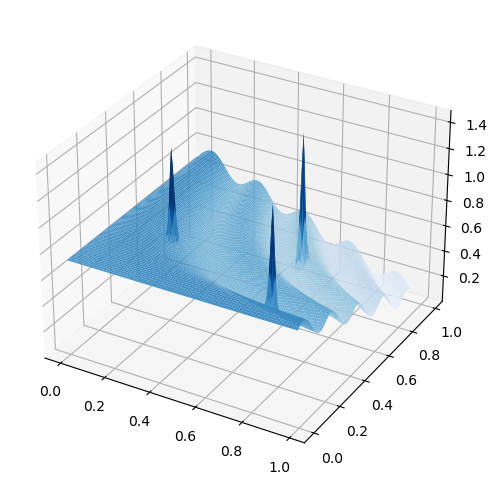

In [4]:
# visualize canonical problem
def mme_add_2d_plot(x1, x2):
    y = (torch.exp(-(100.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(100.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(100.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = mme_add_2d_plot(X1, X2)
from matplotlib import ticker, cm
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8,6))

from matplotlib.colors import LightSource
ls = LightSource(270, 45)
rgb = ls.shade(Z.numpy(), cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0)
# surf = ax.plot_surface(X1, X2, Z, facecolors=rgb, shade=False)
# plt.savefig(datasavedir + '/'+'2d_mean_behavior_surface'+'.png')

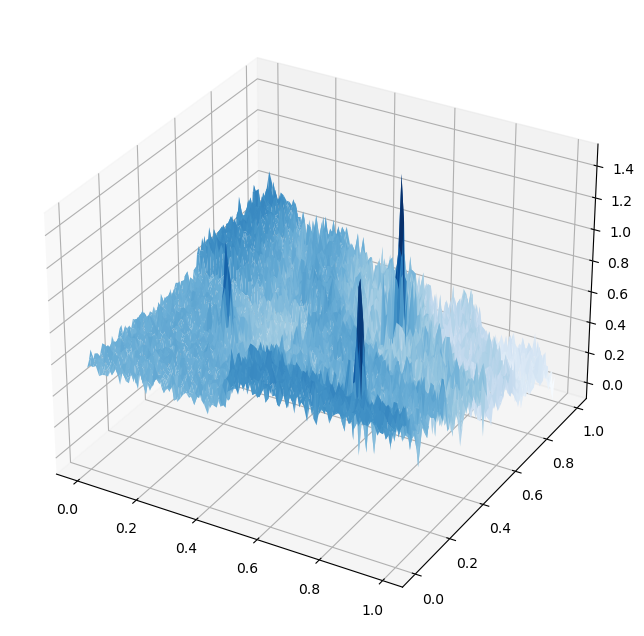

In [5]:
# visualizing with noise added
sigma_max = 0.12
sigma_min = 0.02
def noise_1_2d(x1, x2):
    # mean
    y = mme_add_2d_plot(x1, x2)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0)
# plt.savefig(datasavedir + '/'+'2d_mme_noisyjump_surface'+'.png')

In [6]:
# formatting objective function to match the input format for botorch
sigma_max = 0.12
sigma_min = 0.02
def mme_add_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    y = (torch.exp(-(100.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(100.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(100.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

def mme_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    # mean
    y = mme_add_2d(X)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

def outcome_objective(x):
    """wrapper for the outcome objective function"""
    return mme_2d(x).type_as(x).unsqueeze(-1)

In [7]:
# functions for getting and working with data from searches
def get_bounds(graph):
    """Get the bounds for each node in a graph to be able to plot them"""
    graph_leaves = [n for n in graph if graph.out_degree[n] == 0]
    bound_list = []
    node_list = []
    for n in graph_leaves:
        # get current leaf node
        current_node = graph.nodes()[n]
        current_state = current_node['data']
        current_bounds = current_state.local_bounds
        node_list.append(n)
        bound_list.append(current_bounds)
    return node_list, bound_list

def plot_2d_contour_search_evaluations(search_obj: MultimodalExtremaSearch, rep: int):
    """Use the data from the search object to plot a 2d contour plot"""
    x_plot = search_obj.global_state.x_global
    node_list, leaf_bounds = get_bounds(search_obj.global_state.partition_graph)
    fig1, ax1 = plt.subplots()
    CS = ax1.contour(X1, X2, Z, levels=15, cmap='Blues')
    cbar = fig1.colorbar(CS)
    ax1.scatter(x_plot[:,0].numpy()[0:10], x_plot[:,1].numpy()[0:10], s=15, marker='o', color='tab:orange', zorder=2)
    ax1.scatter(x_plot[:,0].numpy()[10:], x_plot[:,1].numpy()[10:], s=15, marker='o', color='g', zorder=2)
    for i in range(len(leaf_bounds)):
        ax1.plot([leaf_bounds[i][0,0], leaf_bounds[i][1,0]], [leaf_bounds[i][0,1], leaf_bounds[i][0,1]], color='k')
        ax1.plot([leaf_bounds[i][1,0], leaf_bounds[i][1,0]], [leaf_bounds[i][0,1], leaf_bounds[i][1,1]], color='k')
        ax1.plot([leaf_bounds[i][1,0], leaf_bounds[i][0,0]], [leaf_bounds[i][1,1], leaf_bounds[i][1,1]], color='k')
        ax1.plot([leaf_bounds[i][0,0], leaf_bounds[i][0,0]], [leaf_bounds[i][1,1], leaf_bounds[i][0,1]], color='k')
    ax1.set_xlim([-0.01,1.01])
    ax1.set_ylim([-0.01,1.01])
    ax.set_title('PIONEER_rep{}'.format(rep))
#     plt.savefig(datasavedir + '/'+'2d_mme_noise_pioneer_evals_contour_rep{}'.format(rep)+'.png')
    plt.savefig(strtime+'2d_mme_noise_pioneer_evals_contour_rep{}'.format(rep)+'.png')

def get_bounds_all(graph):
    """Get the bounds for each node in a graph to be able to plot them"""
    graph_nodes = [n for n in graph]
    bound_list = []
    node_list = []
    for n in graph_nodes:
        # get current node
        current_node = graph.nodes()[n]
        current_state = current_node['data']
        current_bounds = current_state.local_bounds
        node_list.append(n)
        bound_list.append(current_bounds)
    return node_list, bound_list

def plot_current_tree(global_search: MultimodalExtremaSearch, rep):
    """Save a plot of the tree structure after the search"""
    # tree figure
    T = global_search.global_state.partition_graph
    pos = nx.nx_agraph.graphviz_layout(T, prog="dot")
    # bounds to put on nodes on plot
    all_nodes, all_bounds = get_bounds_all(global_search.global_state.partition_graph)
    # positioning of bound text
    pos_attrs = {}
    for node, coords in pos.items():
        pos_attrs[node] = (coords[0]-35, coords[1]-5)
    custom_node_attrs = {}
    for node, attrs in zip(all_nodes, all_bounds):
        custom_node_attrs[node] = str(attrs.numpy().round(decimals=3))
    # plot commands
    f, ax = plt.subplots(1, 1, figsize=(20, 8), constrained_layout=True)
    nx.draw(T, pos, with_labels=True, font_weight='bold', ax=ax)
    nx.draw_networkx_labels(T, pos_attrs, labels=custom_node_attrs, ax=ax)
    ax.set_title('PIONEER Partition Tree')
    plt.savefig(datasavedir + '/'+'partition_tree_rep{}'.format(rep)+'.png')

In [8]:
# metrics functions
def count_number_peaks_observed_2d(x_obs, y_obs, num_known_peaks=3):
    """Function to count the number of peaks observed for the mme_noise_jump_1d function"""
    peak1, peak2, peak3 = False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.64 <= x[0] <= 0.66 and 0.64 <= x[1] <= 0.66:
            if y >= 1.37:
                peak1 = True
        elif 0.24 <= x[0] <= 0.26 and 0.34 <= x[1] <= 0.36:
            if y >= 1.06:
                peak2 = True
        elif 0.79 <= x[0] <= 0.81 and 0.14 <= x[1] <= 0.16:
            if y >= 1.36:
                peak3 = True
    num_peaks_observed = peak1 + peak2 + peak3
    return num_peaks_observed


def count_evaluations_for_all_peaks_2d(x_obs, y_obs):
    """Count the number of function evaluations before finding all peaks"""
    i = 0
    num_evals_for_all_peaks = x_obs.shape[0]
    peak1, peak2, peak3 = False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.64 <= x[0] <= 0.66 and 0.64 <= x[1] <= 0.66:
            if y >= 1.37:
                peak1 = True
        elif 0.24 <= x[0] <= 0.26 and 0.34 <= x[1] <= 0.36:
            if y >= 1.06:
                peak2 = True
        elif 0.79 <= x[0] <= 0.81 and 0.14 <= x[1] <= 0.16:
            if y >= 1.36:
                peak3 = True
        i += 1
        if peak1 and peak2 and peak3:
            num_evals_for_all_peaks = i
            break
    return num_evals_for_all_peaks


Trial  1 of 4 Collecting initial samples
Setting up global state
tead
tead
tead
tead
tead
tead
tead
tead
tead
tead
tead


/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  0  tead score:  tensor(1.1996, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: Selecting node  0  for split with score  1.1996068283083943
Running partition
PARTITION: Splitting node  0  from  tensor([[0., 0.],
        [1., 1.]], dtype=torch.float64)  to  tensor([[0.0000, 0.0000],
        [1.0000, 0.5000]], dtype=torch.float64)  and  tensor([[0.0000, 0.5000],
        [1.0000, 1.0000]], dtype=torch.float64)
PARTITION: New node  1  new edge from  0  to  1
PARTITION: New node  2  new edge from  0  to  2
Running subdomain selection
SELECT: For node  1  best x:  tensor([[0.0340, 0.0290]], dtype=torch.float64)  best tead:  1.2057311020083377
SELECT: For node  2  best

tead
tead
LOCALSEARCH: Completed  2  new tead evaluations 
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
LOCALSEARCH: Completed  11  new turbo evaluations
Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  4  tead score:  tensor(1.2853, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  6  tead score:  tensor(1.2994, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  7  tead score:  tensor(1.0482, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  8  tead score:  tensor(1.3519, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  9  tead score:  tensor(1.4231, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  10  tead score:  

Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  4  tead score:  tensor(1.5169, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  6  tead score:  tensor(1.3506, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  7  tead score:  tensor(1.0244, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  10  tead score:  tensor(1.3106, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  12  tead score:  tensor(1.4077, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  13  tead score:  tensor(1.3489, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  14  tead score:  tensor(1.1915, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  15  tead score:  tensor(1.4502, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  16  tead score

tead
tead
LOCALSEARCH: Completed  2  new tead evaluations 
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
LOCALSEARCH: Completed  11  new turbo evaluations
Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  6  tead score:  tensor(1.0160, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  7  tead score:  tensor(1.0087, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  12  tead score:  tensor(1.1613, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  13  tead score:  tensor(0.9807, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  14  tead score:  tensor(1.1450, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  16  tead score

SELECT: For node  6  best x:  tensor([[0.6084, 0.2308]], dtype=torch.float64)  best tead:  0.8482959051438832
SELECT: For node  7  best x:  tensor([[0.3546, 0.0313]], dtype=torch.float64)  best tead:  0.8097993082667914
SELECT: For node  12  best x:  tensor([[0.3189, 0.6935]], dtype=torch.float64)  best tead:  0.6634400543404453
SELECT: For node  13  best x:  tensor([[0.8902, 0.5184]], dtype=torch.float64)  best tead:  0.5453264227190239
SELECT: For node  14  best x:  tensor([[0.3629, 0.5795]], dtype=torch.float64)  best tead:  0.7364014831082117
SELECT: For node  16  best x:  tensor([[0.7532, 0.0056]], dtype=torch.float64)  best tead:  0.5688119760825165
SELECT: For node  17  best x:  tensor([[0.9766, 0.3550]], dtype=torch.float64)  best tead:  1.3069201239918615
SELECT: For node  19  best x:  tensor([[0.7165, 0.0014]], dtype=torch.float64)  best tead:  0.6563715379045822
SELECT: For node  20  best x:  tensor([[0.7091, 0.1233]], dtype=torch.float64)  best tead:  0.5652731151706264
SEL

SELECT: For node  7  best x:  tensor([[0.3096, 0.0564]], dtype=torch.float64)  best tead:  0.6403750076316032
SELECT: For node  12  best x:  tensor([[0.3593, 0.6598]], dtype=torch.float64)  best tead:  0.6357855530754319
SELECT: For node  13  best x:  tensor([[0.4953, 0.5489]], dtype=torch.float64)  best tead:  0.657417063997972
SELECT: For node  14  best x:  tensor([[0.6538, 0.6151]], dtype=torch.float64)  best tead:  0.6562878986617867
SELECT: For node  16  best x:  tensor([[0.7832, 0.0993]], dtype=torch.float64)  best tead:  0.5276428357026277
SELECT: For node  17  best x:  tensor([[0.0025, 0.3479]], dtype=torch.float64)  best tead:  0.7033097694339271
SELECT: For node  19  best x:  tensor([[0.5948, 0.0559]], dtype=torch.float64)  best tead:  0.586018463874261
SELECT: For node  20  best x:  tensor([[0.6104, 0.0640]], dtype=torch.float64)  best tead:  0.5737354438126232
SELECT: For node  24  best x:  tensor([[0.4659, 0.9795]], dtype=torch.float64)  best tead:  0.7073661001476218
SELE

SELECT: For node  7  best x:  tensor([[0.3741, 0.0735]], dtype=torch.float64)  best tead:  0.789303803335146
SELECT: For node  13  best x:  tensor([[0.2147, 0.5074]], dtype=torch.float64)  best tead:  0.8777407064017414
SELECT: For node  14  best x:  tensor([[0.7162, 0.5976]], dtype=torch.float64)  best tead:  0.776172302783612
SELECT: For node  16  best x:  tensor([[0.7629, 0.0087]], dtype=torch.float64)  best tead:  0.7901388917408342
SELECT: For node  19  best x:  tensor([[0.5023, 0.0495]], dtype=torch.float64)  best tead:  0.7898622887180772
SELECT: For node  20  best x:  tensor([[0.5065, 0.0629]], dtype=torch.float64)  best tead:  0.7322847905201172
SELECT: For node  24  best x:  tensor([[0.4815, 0.9492]], dtype=torch.float64)  best tead:  0.6955193279355358
SELECT: For node  25  best x:  tensor([[0.5148, 0.7670]], dtype=torch.float64)  best tead:  0.8001317348337849
SELECT: For node  26  best x:  tensor([[0.7922, 0.8398]], dtype=torch.float64)  best tead:  0.8149877032069733
SELE

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  0  tead score:  tensor(1.3087, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: Selecting node  0  for split with score  1.308718920048782
Running partition
PARTITION: Splitting node  0  from  tensor([[0., 0.],
        [1., 1.]], dtype=torch.float64)  to  tensor([[0.0000, 0.0000],
        [1.0000, 0.5000]], dtype=torch.float64)  and  tensor([[0.0000, 0.5000],
        [1.0000, 1.0000]], dtype=torch.float64)
PARTITION: New node  1  new edge from  0  to  1
PARTITION: New node  2  new edge from  0  to  2
Running subdomain selection
SELECT: For node  1  best x:  tensor([[0.0195, 0.2899]], dtype=torch.float64)  best tead:  1.3388296563797766
SELECT: For node  2  best 

tead
tead
LOCALSEARCH: Completed  2  new tead evaluations 
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
LOCALSEARCH: Completed  11  new turbo evaluations
Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  5  tead score:  tensor(1.2883, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  6  tead score:  tensor(1.2925, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  7  tead score:  tensor(1.0579, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  8  tead score:  tensor(1.1112, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  9  tead score:  tensor(1.1956, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  10  tead score:  

SELECT: For node  5  best x:  tensor([[0.5572, 0.9956]], dtype=torch.float64)  best tead:  1.175642053137556
SELECT: For node  7  best x:  tensor([[0.0944, 0.9977]], dtype=torch.float64)  best tead:  1.2165928348975734
SELECT: For node  9  best x:  tensor([[0.3931, 0.4068]], dtype=torch.float64)  best tead:  1.2079466968885646
SELECT: For node  13  best x:  tensor([[0.9390, 0.5701]], dtype=torch.float64)  best tead:  0.8244752948521639
SELECT: For node  14  best x:  tensor([[0.8949, 0.9834]], dtype=torch.float64)  best tead:  0.9818567387564114
SELECT: For node  15  best x:  tensor([[0.3091, 0.6173]], dtype=torch.float64)  best tead:  1.1488463816636192
SELECT: For node  16  best x:  tensor([[0.3901, 0.7945]], dtype=torch.float64)  best tead:  1.0122007005990963
SELECT: For node  17  best x:  tensor([[0.5398, 0.1348]], dtype=torch.float64)  best tead:  1.18221188119969
SELECT: For node  18  best x:  tensor([[0.9500, 0.4998]], dtype=torch.float64)  best tead:  1.2411095241151036
SELECT:

tead
tead
LOCALSEARCH: Completed  2  new tead evaluations 
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
LOCALSEARCH: Completed  11  new turbo evaluations
Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  7  tead score:  tensor(1.1956, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  13  tead score:  tensor(0.8315, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  14  tead score:  tensor(1.0410, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  15  tead score:  tensor(0.8964, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  16  tead score:  tensor(1.0764, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  17  tead scor

Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  7  tead score:  tensor(0.7974, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  13  tead score:  tensor(0.7596, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  14  tead score:  tensor(0.6985, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  15  tead score:  tensor(0.8263, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  16  tead score:  tensor(0.8272, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  17  tead score:  tensor(0.7739, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  18  tead score:  tensor(0.6989, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: Fo

tead
tead
LOCALSEARCH: Completed  2  new tead evaluations 
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
LOCALSEARCH: Completed  11  new turbo evaluations
Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  7  tead score:  tensor(0.8517, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  13  tead score:  tensor(0.7805, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  14  tead score:  tensor(0.7036, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  15  tead score:  tensor(0.6947, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  17  tead score:  tensor(0.8605, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  18  tead scor

tead
tead
LOCALSEARCH: Completed  2  new tead evaluations 
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
LOCALSEARCH: Completed  11  new turbo evaluations
Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
tead
tead


/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  0  tead score:  tensor(1.1777, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: Selecting node  0  for split with score  1.177694684782607
Running partition
PARTITION: Splitting node  0  from  tensor([[0., 0.],
        [1., 1.]], dtype=torch.float64)  to  tensor([[0.0000, 0.0000],
        [0.5000, 1.0000]], dtype=torch.float64)  and  tensor([[0.5000, 0.0000],
        [1.0000, 1.0000]], dtype=torch.float64)
PARTITION: New node  1  new edge from  0  to  1
PARTITION: New node  2  new edge from  0  to  2
Running subdomain selection
SELECT: For node  1  best x:  tensor([[0.4857, 0.8233]], dtype=torch.float64)  best tead:  1.4973817810252124
SELECT: For node  2  best 

tead
tead
LOCALSEARCH: Completed  2  new tead evaluations 
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
LOCALSEARCH: Completed  11  new turbo evaluations
Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  3  tead score:  tensor(1.1843, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  5  tead score:  tensor(1.2878, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  7  tead score:  tensor(1.3372, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  8  tead score:  tensor(1.3381, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  9  tead score:  tensor(1.2775, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  10  tead score:  

Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  3  tead score:  tensor(0.7376, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  5  tead score:  tensor(1.0798, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  9  tead score:  tensor(0.7244, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  11  tead score:  tensor(0.7811, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  12  tead score:  tensor(0.6158, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  13  tead score:  tensor(0.6906, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  14  tead score:  tensor(0.9252, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  15  tead score:  tensor(0.9184, dtype=torch.float64, grad_fn=<MaxBackward1

tead
tead
LOCALSEARCH: Completed  2  new tead evaluations 
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
LOCALSEARCH: Completed  11  new turbo evaluations
Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  3  tead score:  tensor(1.1482, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  9  tead score:  tensor(1.0593, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  11  tead score:  tensor(1.3254, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  12  tead score:  tensor(1.3460, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  13  tead score:  tensor(0.8871, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  15  tead score

SELECT: For node  3  best x:  tensor([[0.0088, 0.0168]], dtype=torch.float64)  best tead:  1.0279537503011262
SELECT: For node  9  best x:  tensor([[0.3777, 0.7125]], dtype=torch.float64)  best tead:  0.9268201003941805
SELECT: For node  11  best x:  tensor([[0.8418, 0.7966]], dtype=torch.float64)  best tead:  1.0236111675295936
SELECT: For node  13  best x:  tensor([[0.5917, 0.5224]], dtype=torch.float64)  best tead:  0.8089941151214766
SELECT: For node  15  best x:  tensor([[0.2450, 0.7584]], dtype=torch.float64)  best tead:  0.4385898322947852
SELECT: For node  18  best x:  tensor([[0.7833, 0.4848]], dtype=torch.float64)  best tead:  0.9352492396276663
SELECT: For node  19  best x:  tensor([[0.6876, 0.5127]], dtype=torch.float64)  best tead:  0.8396488758957035
SELECT: For node  20  best x:  tensor([[0.6594, 0.8032]], dtype=torch.float64)  best tead:  0.6810219323394165
SELECT: For node  21  best x:  tensor([[0.6128, 0.2297]], dtype=torch.float64)  best tead:  0.3716405316486525
SEL

SELECT: For node  9  best x:  tensor([[0.1225, 0.6825]], dtype=torch.float64)  best tead:  0.9058103628690067
SELECT: For node  13  best x:  tensor([[0.5543, 0.9268]], dtype=torch.float64)  best tead:  0.8131426255700009
SELECT: For node  15  best x:  tensor([[0.2061, 0.9814]], dtype=torch.float64)  best tead:  0.7595080672425666
SELECT: For node  18  best x:  tensor([[0.8275, 0.4471]], dtype=torch.float64)  best tead:  1.05307672355639
SELECT: For node  19  best x:  tensor([[0.6375, 0.5760]], dtype=torch.float64)  best tead:  0.821895803040829
SELECT: For node  20  best x:  tensor([[0.6501, 0.8011]], dtype=torch.float64)  best tead:  0.6613293674144678
SELECT: For node  21  best x:  tensor([[0.5365, 0.0018]], dtype=torch.float64)  best tead:  0.1617758429619615
SELECT: For node  22  best x:  tensor([[0.7161, 0.4463]], dtype=torch.float64)  best tead:  0.5655444637768269
SELECT: For node  24  best x:  tensor([[0.9639, 0.7648]], dtype=torch.float64)  best tead:  0.6966936610207625
SELEC

SELECT: For node  9  best x:  tensor([[0.3730, 0.7155]], dtype=torch.float64)  best tead:  0.777017008096091
SELECT: For node  13  best x:  tensor([[0.5427, 0.8043]], dtype=torch.float64)  best tead:  0.779871536730452
SELECT: For node  15  best x:  tensor([[0.2368, 0.9207]], dtype=torch.float64)  best tead:  0.33210662824888354
SELECT: For node  18  best x:  tensor([[0.7749, 0.3474]], dtype=torch.float64)  best tead:  0.4165236476465709
SELECT: For node  19  best x:  tensor([[0.6272, 0.5754]], dtype=torch.float64)  best tead:  0.862938692292847
SELECT: For node  20  best x:  tensor([[0.6789, 0.8235]], dtype=torch.float64)  best tead:  0.6883485204395805
SELECT: For node  21  best x:  tensor([[0.6182, 0.0268]], dtype=torch.float64)  best tead:  0.33093309670585513
SELECT: For node  22  best x:  tensor([[0.5861, 0.4212]], dtype=torch.float64)  best tead:  0.6763997010677509
SELECT: For node  24  best x:  tensor([[0.9447, 0.9353]], dtype=torch.float64)  best tead:  0.7644387571774065
SEL

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  0  tead score:  tensor(1.4551, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: Selecting node  0  for split with score  1.4551417430771134
Running partition
PARTITION: Splitting node  0  from  tensor([[0., 0.],
        [1., 1.]], dtype=torch.float64)  to  tensor([[0.0000, 0.0000],
        [1.0000, 0.5000]], dtype=torch.float64)  and  tensor([[0.0000, 0.5000],
        [1.0000, 1.0000]], dtype=torch.float64)
PARTITION: New node  1  new edge from  0  to  1
PARTITION: New node  2  new edge from  0  to  2
Running subdomain selection
SELECT: For node  1  best x:  tensor([[0.0685, 0.2013]], dtype=torch.float64)  best tead:  1.672082284137213
SELECT: For node  2  best 

tead
tead
LOCALSEARCH: Completed  2  new tead evaluations 
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
LOCALSEARCH: Completed  11  new turbo evaluations
Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  3  tead score:  tensor(1.2219, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  4  tead score:  tensor(1.1431, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  5  tead score:  tensor(1.1717, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  8  tead score:  tensor(1.1483, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  9  tead score:  tensor(0.9362, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  10  tead score:  

Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  4  tead score:  tensor(1.1127, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  8  tead score:  tensor(1.4652, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  9  tead score:  tensor(1.2622, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  10  tead score:  tensor(1.3123, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  12  tead score:  tensor(1.0620, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  13  tead score:  tensor(1.1830, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  14  tead score:  tensor(0.5059, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  15  tead score:  tensor(1.1898, dtype=torch.float64, grad_fn=<MaxBackward1

tead
tead
LOCALSEARCH: Completed  2  new tead evaluations 
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
LOCALSEARCH: Completed  11  new turbo evaluations
Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  10  tead score:  tensor(0.8300, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  12  tead score:  tensor(0.9347, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  13  tead score:  tensor(1.0669, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  14  tead score:  tensor(0.5179, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  15  tead score:  tensor(1.2055, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: For node  16  tead sco

SELECT: For node  10  best x:  tensor([[0.9506, 0.5926]], dtype=torch.float64)  best tead:  0.8028408594457787
SELECT: For node  12  best x:  tensor([[0.4597, 0.1362]], dtype=torch.float64)  best tead:  0.9820014032597665
SELECT: For node  14  best x:  tensor([[0.5011, 0.0464]], dtype=torch.float64)  best tead:  0.49602688390468186
SELECT: For node  16  best x:  tensor([[0.3093, 0.8186]], dtype=torch.float64)  best tead:  1.0344796211458944
SELECT: For node  17  best x:  tensor([[0.5909, 0.9971]], dtype=torch.float64)  best tead:  1.027706023570644
SELECT: For node  18  best x:  tensor([[0.9884, 0.9433]], dtype=torch.float64)  best tead:  0.9862617701094193
SELECT: For node  19  best x:  tensor([[0.5136, 0.5858]], dtype=torch.float64)  best tead:  0.6033765348081637
SELECT: For node  20  best x:  tensor([[0.7127, 0.6667]], dtype=torch.float64)  best tead:  0.46994667029792775
SELECT: For node  22  best x:  tensor([[0.9622, 0.3140]], dtype=torch.float64)  best tead:  1.0288328322472482


SELECT: For node  10  best x:  tensor([[0.7506, 0.7389]], dtype=torch.float64)  best tead:  1.1352258603155667
SELECT: For node  12  best x:  tensor([[0.8641, 0.2086]], dtype=torch.float64)  best tead:  1.1303767448469964
SELECT: For node  14  best x:  tensor([[0.6969, 0.0071]], dtype=torch.float64)  best tead:  0.5910111362724765
SELECT: For node  17  best x:  tensor([[0.5084, 0.7632]], dtype=torch.float64)  best tead:  1.0620478655227095
SELECT: For node  18  best x:  tensor([[0.9994, 0.9402]], dtype=torch.float64)  best tead:  1.1274097506657914
SELECT: For node  19  best x:  tensor([[0.6828, 0.5735]], dtype=torch.float64)  best tead:  1.1441663873150654
SELECT: For node  20  best x:  tensor([[0.7107, 0.7063]], dtype=torch.float64)  best tead:  1.1078152173939164
SELECT: For node  22  best x:  tensor([[0.9733, 0.3166]], dtype=torch.float64)  best tead:  1.1346708727939894
SELECT: For node  23  best x:  tensor([[0.1624, 0.4605]], dtype=torch.float64)  best tead:  0.9998847452712821
S

SELECT: For node  10  best x:  tensor([[0.7583, 0.7385]], dtype=torch.float64)  best tead:  1.0069239486879202
SELECT: For node  12  best x:  tensor([[0.8325, 0.1817]], dtype=torch.float64)  best tead:  1.1618626437028448
SELECT: For node  14  best x:  tensor([[0.6875, 0.0305]], dtype=torch.float64)  best tead:  1.0804214508702565
SELECT: For node  17  best x:  tensor([[0.5910, 0.9985]], dtype=torch.float64)  best tead:  1.0727997935934739
SELECT: For node  18  best x:  tensor([[0.8670, 0.9176]], dtype=torch.float64)  best tead:  0.9974444311292925
SELECT: For node  20  best x:  tensor([[0.7312, 0.7225]], dtype=torch.float64)  best tead:  1.1323325133377424
SELECT: For node  22  best x:  tensor([[0.9722, 0.3104]], dtype=torch.float64)  best tead:  1.1292016026794987
SELECT: For node  23  best x:  tensor([[0.0775, 0.2767]], dtype=torch.float64)  best tead:  1.0984265398668467
SELECT: For node  24  best x:  tensor([[0.4337, 0.4553]], dtype=torch.float64)  best tead:  0.9691927674585161
S

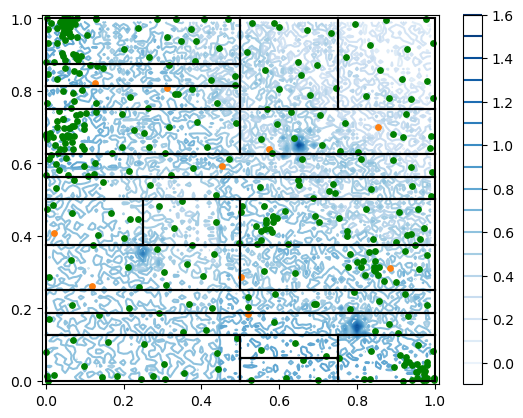

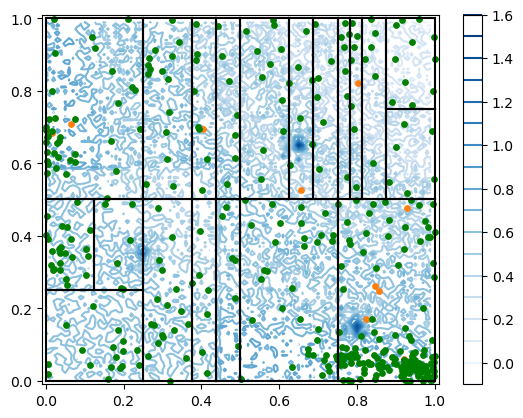

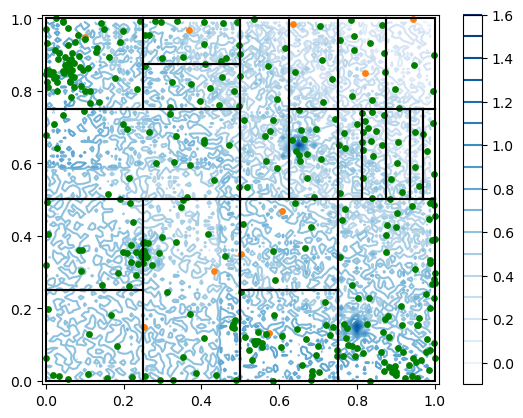

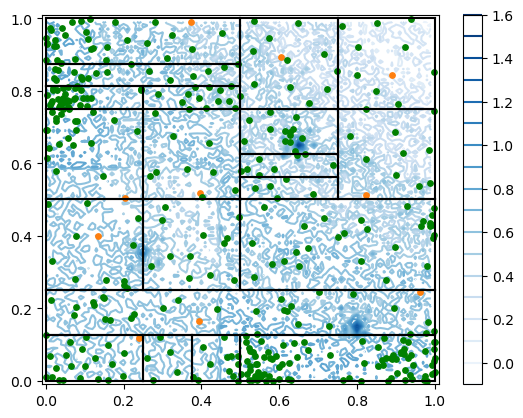

In [9]:
# replicated searches

# search and experiment settings
n_replications = 4
n_evals = 400

# data holders
x_observed_all = []
y_observed_all = []
distinct_peaks = []
function_evaluations = []

# experiment loop
for rep in range(1, n_replications + 1):
    print(f"\nTrial {rep:>2} of {n_replications} ", end="")
    strtime = str(curDatetime.strftime('%Y%m%d%H%M%S'))
    t0 = time.monotonic()
    # initialize search
    current_search = MultimodalExtremaSearch(obj_func=outcome_objective,
                                             input_dim=2,
                                             total_iteration_limit=n_evals)
    # run search
    current_search.run_global_search()
    # collect data
    x_observed_all.append(current_search.global_state.x_global)
    y_observed_all.append(current_search.global_state.y_global)
    # run and save plots
    plot_2d_contour_search_evaluations(current_search, rep)
#     plot_current_tree(current_search, rep)
    # calculate metrics
    num_peaks_observed = count_number_peaks_observed_2d(current_search.global_state.x_global,
                                                        current_search.global_state.y_global)
    print("Observed {num:} peaks".format(num=num_peaks_observed),)
    distinct_peaks.append(num_peaks_observed)
    fe = count_evaluations_for_all_peaks_2d(current_search.global_state.x_global,
                                            current_search.global_state.y_global)
    print("Function evaluations to find all peaks: {}".format(fe))
    function_evaluations.append(fe)
    # time for search
    t1 = time.monotonic()
    print("Time to complete search: {}".format(t1-t0))

In [10]:
# calculate summary metrics
# peak ratio
num_known_peaks = 3
peak_ratio = sum(distinct_peaks) / (num_known_peaks * n_replications)
print("Peak ratio: {}".format(peak_ratio))
# success rate
num_successes = 0
for i in range(n_replications):
    if distinct_peaks[i] == 3:
        num_successes += 1
success_ratio = num_successes / n_replications
print("Success ratio: {}".format(success_ratio))
print("Average function evaluations: {}".format(sum(function_evaluations)/n_replications))

Peak ratio: 0.08333333333333333
Success ratio: 0.0
Average function evaluations: 401.0


In [13]:
# save data to file for potential future use
methods_list = ['PIONEER']
pr_list = [peak_ratio]
sr_list = [success_ratio]
fe_list = [function_evaluations]
import pickle
# with open(datasavedir + '/' + '2d_pioneer_mme_metrics.pkl', 'wb') as f:
with open(strtime + ' 2d_pioneer_mme_metrics.pkl', 'wb') as f:
    pickle.dump([methods_list, pr_list, sr_list, fe_list], f)
# to retrieve
# with open(datasavedir + '/' + 'mme_metrics.pkl') as f:
#     methods_list, pr_list, sr_list, fe_list = pickle.load(f)

In [12]:
strtime

'20230320141143'